# Matching image contrast and intensity

This script reads a set of images from a folder and modifies them to all have
the same mean pixel value and the same standard deviation of the pixel values.
By approximation, this equates the intensity and contrast of the images, but
not perfectly so, as intensity and contrast are physical properties that also
depend on the monitor.

For more information, please refer to:

- Mathôt, S., & Vilotijević, A. (2022). Methods in Pupillometry: Design,
  Preprocessing, and Statistical Analysis. *bioRxiv*.
  doi:10.1101/2022.02.23.481628


First, we read all images into a single numpy array. This numpy array has four
dimensions, where the first dimension corresponds to the number of images, and
the remaining dimensions correspond to the dimensions of the images.

C:\Users\arturoV\AppData\Local\Temp\ipykernel_29228\1703991584.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  shape_images = imageio.imread(files[0]).shape
C:\Users\arturoV\AppData\Local\Temp\ipykernel_29228\1703991584.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(filename)


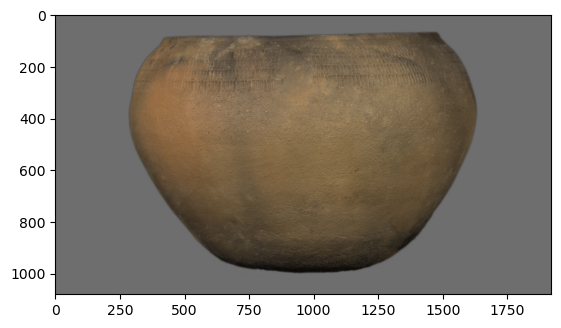

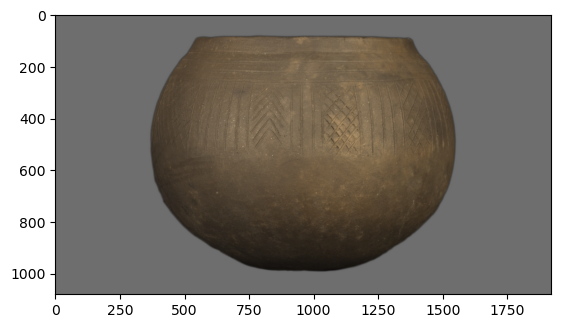

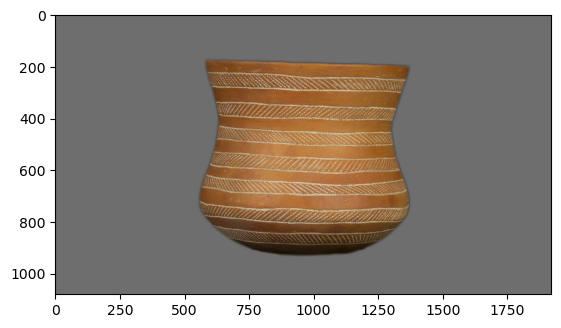

Read 3 images with shape (1080, 1920, 3) from original-images.


In [1]:
%matplotlib inline
import imageio
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import cv2
SOURCE_FOLDER = r'original-images'
DEST_FOLDER = 'matched-images'

files = list(Path(SOURCE_FOLDER).iterdir())
n_images = len(files)
shape_images = imageio.imread(files[0]).shape
images = np.zeros((n_images,) + shape_images, dtype=float)
for i, filename in enumerate(files):
    im = imageio.imread(filename)
    #remove background
    background_color = (110)  # Example: Red background color
    # Compute the mask for the background color
    mask = cv2.inRange(im, background_color, background_color)
    
    # Apply the mask to remove the background color
    image_removed = cv2.bitwise_and(im, im, mask=~mask)
    plt.imshow(image_removed)
    plt.show()
    images[i] = im
    

print(f'Read {n_images} images with shape {shape_images} from {SOURCE_FOLDER}.')

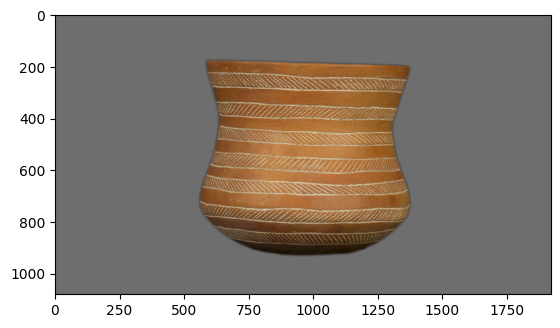

In [101]:
%matplotlib inline
plt.imshow(image_removed)


Let's check the mean pixel value (intensity) and standard deviation (contrast)
of the original images. These likely differ considerable between images.

In [102]:
for i in range(n_images):
    print(f'{i}: intensity={images[i].mean()}, contrast={images[i].std()}')

0: intensity=99.68967528292181, contrast=23.438221943833213
1: intensity=95.98063577031893, contrast=24.655053299928966
2: intensity=109.12451919367284, contrast=25.79294318412048


In [103]:
for i in range(n_images):
    print(f'{i}: intensity={images[i][images[i] !=110].mean()}, contrast={images[i][images[i] !=110].std()}')

0: intensity=89.32512421661495, contrast=29.78764768726998
1: intensity=78.19465296691081, contrast=28.5196842280461
2: intensity=106.67592910199522, contrast=50.17783173143333


To equalize the mean pixel value (intensity) and standard deviation (contrast),
we perform the following steps for each image

- subtract the mean value, thus setting the mean to 0
- divide by the standard deviation of the stimulus, thus setting the standard
  deviation to 1
- multiply by the grand mean (=across all images) standard deviation
- add the grand mean value

In [104]:
STD_REDUCTION = 0.6

grand_mean_intensity = images[images!=110].mean()
grand_mean_std = images[images!=110].std() * STD_REDUCTION
for i in range(n_images):
    images[i][images[i] !=110] -= images[i][images[i] !=110].mean()
    images[i][images[i] !=110] /= images[i][images[i] !=110].std() / grand_mean_std
    images[i][images[i] !=110] += grand_mean_intensity
images = np.clip(images, 0, 255)

Let's check the mean pixel value (intensity) and standard deviation (contrast)
of the matched images. They should be almost identical for all images! If there
are still differences, this is because some of the pixel values were adjusted
to be out of the 0 - 255 range. To avoid this from happening, decrease the
STD_REDUCTION value above. This reduces the contrast for all images, thus
avoiding pixel values from exceeding the 0 - 255 range.

In [105]:
for i in range(n_images):
    print(f'{i}: intensity={images[i].mean()}, contrast={images[i].std()}')

0: intensity=99.5502187680544, contrast=18.661967689788924
1: intensity=100.76353168825342, contrast=17.861652189712654
2: intensity=104.48107979060559, contrast=14.5308957089976


Write the matched images to file and show them.

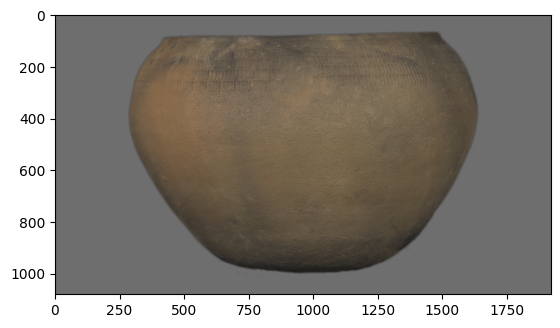

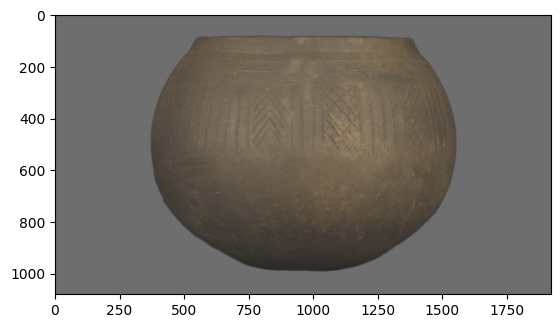

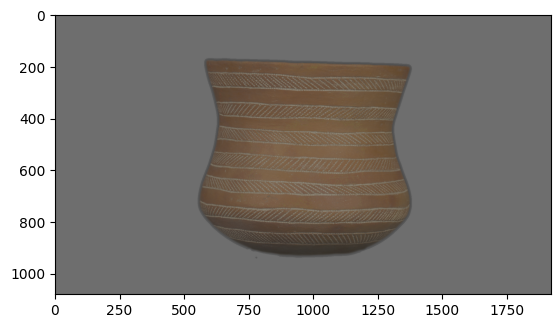

In [106]:
%matplotlib inline
for i, filename in enumerate(files):
    im = np.array(images[i], dtype=np.uint8)
    plt.imshow(im)
    plt.show()
    imageio.imwrite(Path(DEST_FOLDER) / filename.name, im)
    